## LSTM을 활용한 주가 예측 모델
이번 튜토리얼 에서는 다음과 같은 프로세스 파이프라인으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

### 필요한 모듈 import

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

### 데이터 (FinanceDataReader)
FinanceDataReader는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)
FinanceDataReader가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [1]:
# !pip install finance-datareader

  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached lxml-4.6.2-cp38-cp38-win_amd64.whl (3.5 MB)


In [3]:
import FinanceDataReader as fdr

# BUG: ModuleNotFoundError: No module named 'bs4'
# SOL: pip install beautifulsoup4

In [6]:
# import FinanceDataReader as fdr
# sp500 = fdr.StockListing('S&P500')
# sp500.head(10)

C:\Users\ORM005\Anaconda3\envs\mai\lib\site-packages\FinanceDataReader\wikipedia\listing.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Symbol'] = df['Symbol'].str.replace('\.', '')


,Symbol,Name,Sector,Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment
6,ADBE,Adobe Inc.,Information Technology,Application Software
7,AMD,Advanced Micro Devices Inc,Information Technology,Semiconductors
8,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail
9,AES,AES Corp,Utilities,Independent Power Producers & Energy Traders


In [9]:
# Apple(AAPL), 애플
# apple = fdr.DataReader('AAPL')
apple = fdr.DataReader('AAPL', '2017')

apple

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092
...,...,...,...,...,...,...
2021-01-26,143.16,143.67,144.26,141.43,98390000.0,0.0017
2021-01-27,142.06,143.41,144.27,140.48,140840000.0,-0.0077
2021-01-28,137.09,139.65,141.98,136.82,142620000.0,-0.0350


In [19]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
# ConnectionError: HTTPSConnectionPool(host='fchart.stock.naver.com', port=443): Max retries exceeded with url: /sise.nhn?timeframe=day&count=6000&requestType=0&symbol=005930 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000123C5E18A90>: Failed to establish a new connection: [WinError 10060] 연결된 구성원으로부터 응답이 없어 연결하지 못했거나, 호스트로부터 응답이 없어 연결이 끊어졌습니다'))
# samsung = fdr.DataReader('005930', '2019')

# apple(AAPL) 전체 (1996-11-05 ~ 현재)
stock = fdr.DataReader('AAPL')

# 비트코인
# btc = fdr.DataReader('BTC/KRW', '2019')

# btc

# SMIC
# smic = fdr.DataReader('688981')

# smic.tail()


매우 편리하게 삼성전자 주가 데이터를 DataFrame형식으로 받아옵니다.

기본 오름차순 정렬이 된 데이터임을 알 수 있습니다.

#### 컬럼 설명
- Open: 시가
- High: 고가
- Low: 저가
- Close: 종가
- Volume: 거래량
- Change: 대비

In [20]:
stock.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-01-26,143.16,143.67,144.26,141.43,98390000.0,0.0017
2021-01-27,142.06,143.41,144.27,140.48,140840000.0,-0.0077
2021-01-28,137.09,139.65,141.98,136.82,142620000.0,-0.0350
2021-01-29,131.96,135.83,136.74,130.21,177520000.0,-0.0374
2021-02-01,134.14,133.63,135.37,131.06,106240000.0,0.0165


In [21]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [22]:
stock.head()

,Close,Open,High,Low,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1980-12-12,0.13,0.13,0.13,0.13,469030000.0,-0.9988,1980,12,12
1980-12-15,0.12,0.12,0.12,0.12,175880000.0,-0.0769,1980,12,15
1980-12-16,0.11,0.11,0.11,0.11,105730000.0,-0.0833,1980,12,16
1980-12-17,0.12,0.12,0.12,0.12,86440000.0,0.0909,1980,12,17
1980-12-18,0.12,0.12,0.12,0.12,73450000.0,0.0000,1980,12,18


Text(0, 0.5, 'price')

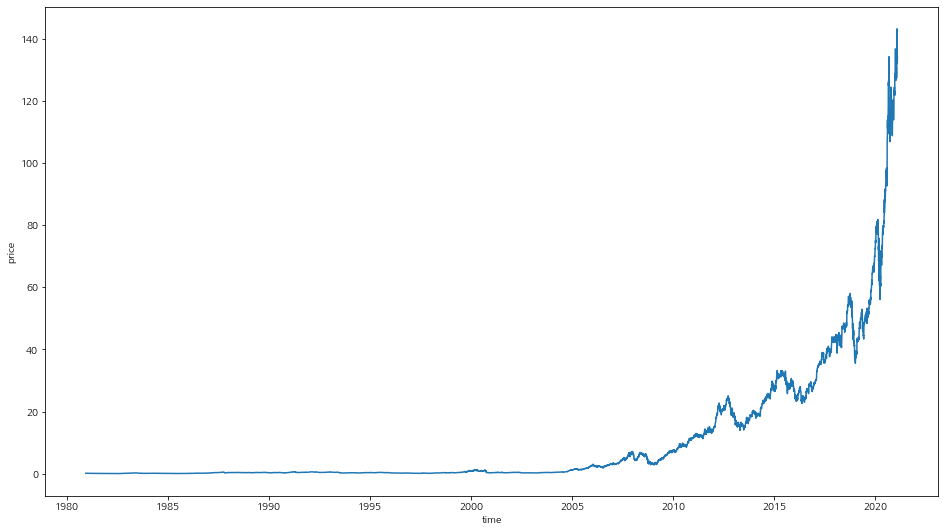

In [25]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

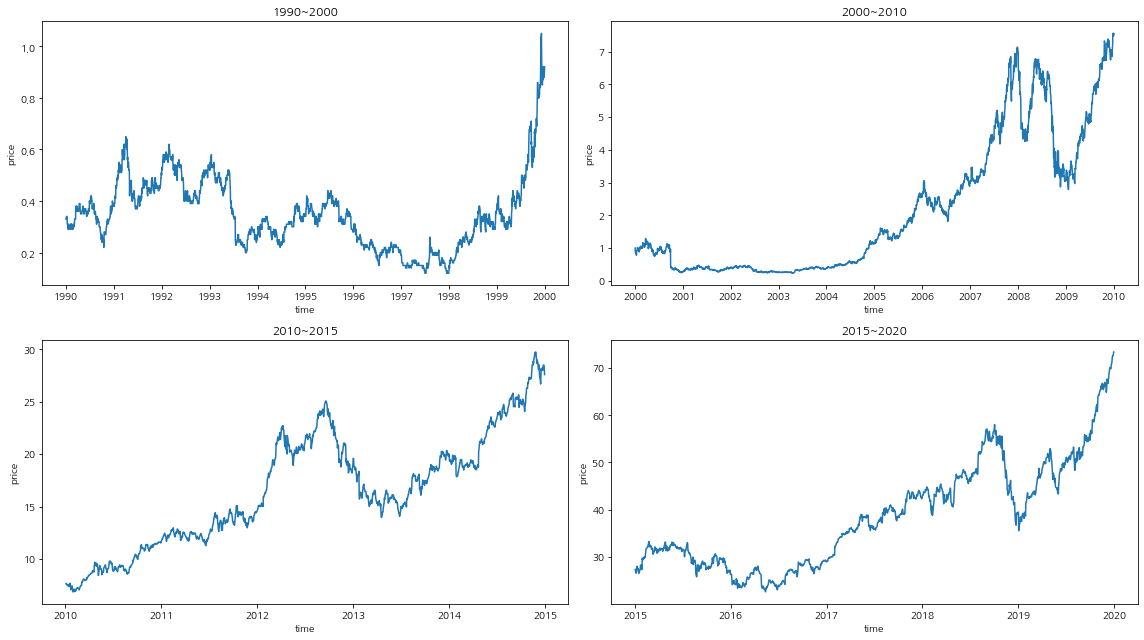

In [26]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리
주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 정규화(Normalization)를 해주도록 하겠습니다.

표준화 (Standardization)와 정규화(Normalization)에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[5.57025484e-04, 5.51800248e-04, 5.65850898e-04, 5.59010551e-04,
        6.29512116e-02],
       [4.87397298e-04, 4.82825217e-04, 4.95119536e-04, 4.89134232e-04,
        2.34889165e-02],
       [4.17769113e-04, 4.13850186e-04, 4.24388174e-04, 4.19257913e-04,
        1.40456963e-02],
       ...,
       [9.72009469e-01, 9.78962616e-01, 9.67392842e-01, 9.57585074e-01,
        1.90116321e-02],
       [9.45411503e-01, 9.42819699e-01, 9.20639412e-01, 9.21738523e-01,
        2.37096846e-02],
       [9.30093302e-01, 9.33370120e-01, 9.26651577e-01, 9.36971560e-01,
        1.41143498e-02]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

시간 순으로 정렬되어 있으며, datetime index는 제외했습니다.

6,000개의 row, 5개 column으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [28]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [30]:
x_train.shape, y_train.shape

((8096, 4), (8096,))

In [31]:
x_test.shape, y_test.shape

((2024, 4), (2024,))

In [32]:
x_train

,Open,High,Low,Volume
0,0.000557,0.000552,0.000566,0.062951
1,0.000487,0.000483,0.000495,0.023489
2,0.000418,0.000414,0.000424,0.014046
3,0.000487,0.000483,0.000495,0.011449
4,0.000487,0.000483,0.000495,0.009700
...,...,...,...,...
8091,0.131110,0.129880,0.129863,0.080735
8092,0.129230,0.129052,0.130782,0.047030
8093,0.124634,0.124638,0.125548,0.098644
8094,0.123590,0.122569,0.121729,0.117839


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [34]:
import tensorflow as tf

In [35]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [36]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [37]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [38]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [40]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [41]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [42]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
253/253 [==============================] - 6s 13ms/step - loss: 3.4655e-06 - mse: 6.9310e-06 - val_loss: 0.0133 - val_mse: 0.0267

Epoch 00001: val_loss improved from inf to 0.01333, saving model to tmp\ckeckpointer.ckpt
Epoch 2/50
253/253 [==============================] - 2s 7ms/step - loss: 1.7736e-06 - mse: 3.5472e-06 - val_loss: 0.0138 - val_mse: 0.0275

Epoch 00002: val_loss did not improve from 0.01333
Epoch 3/50
253/253 [==============================] - 2s 7ms/step - loss: 3.6669e-07 - mse: 7.3339e-07 - val_loss: 0.0138 - val_mse: 0.0276

Epoch 00003: val_loss did not improve from 0.01333
Epoch 4/50
253/253 [==============================] - 2s 7ms/step - loss: 6.3608e-07 - mse: 1.2722e-06 - val_loss: 0.0138 - val_mse: 0.0277

Epoch 00004: val_loss did not improve from 0.01333
Epoch 5/50
253/253 [==============================] - 2s 8ms/step - loss: 3.1293e-07 - mse: 6.2585e-07 - val_loss: 0.0136 - val_mse: 0.0272

Epoch 00005: val_loss did not improve from 0.01333


저장한 ModelCheckpoint 를 로드합니다.

In [43]:
model.load_weights(filename)

test_data를 활용하여 예측을 진행합니다.

In [45]:
pred = model.predict(test_data)

In [46]:
pred.shape

(2004, 1)

## 예측 데이터 시각화
아래 시각화 코드중 y_test 데이터에 [20:]으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않습니다.

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

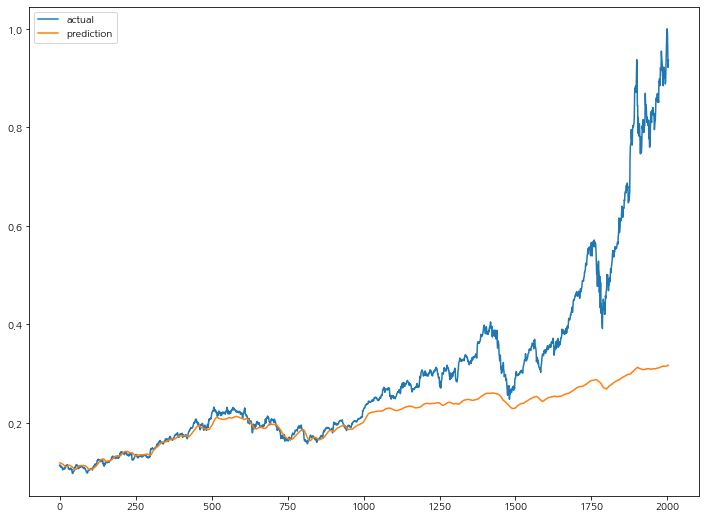

In [47]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()